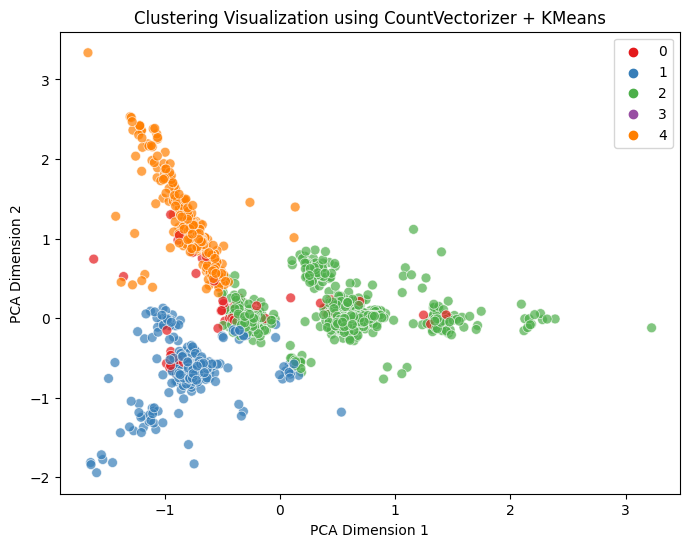

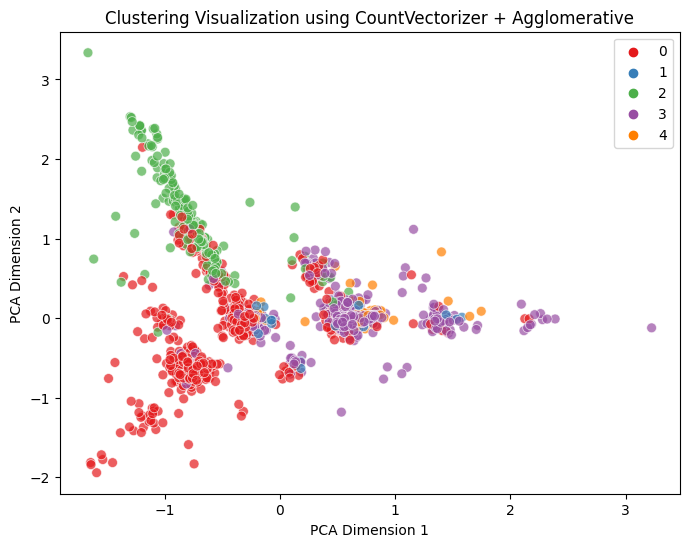

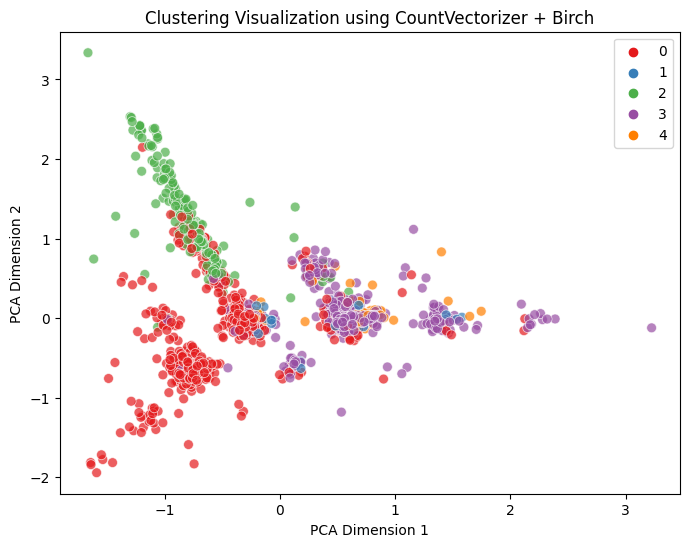

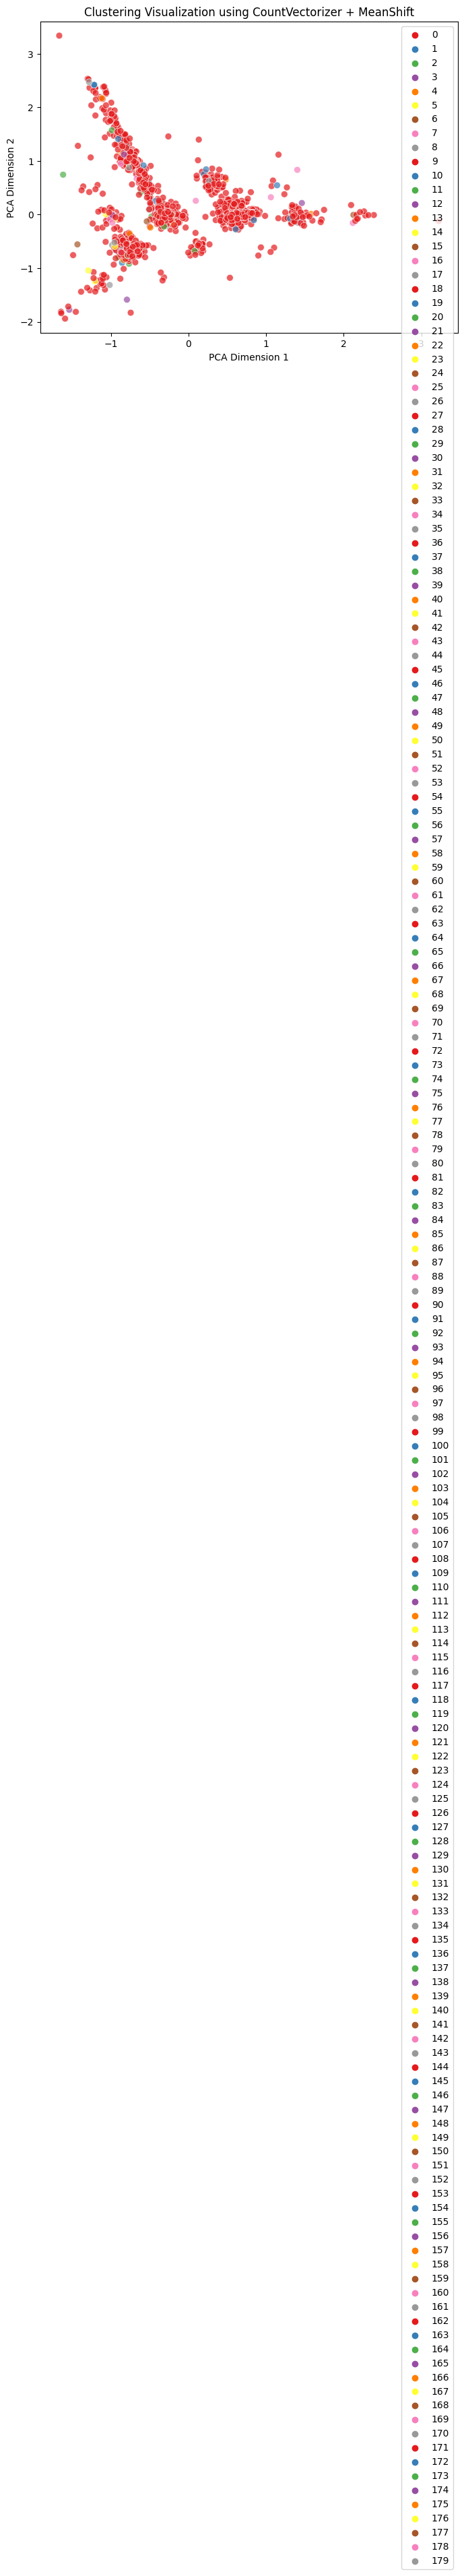

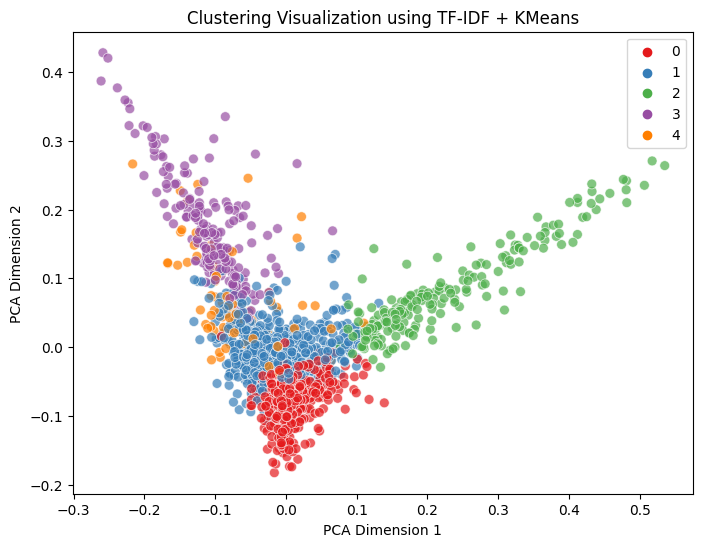

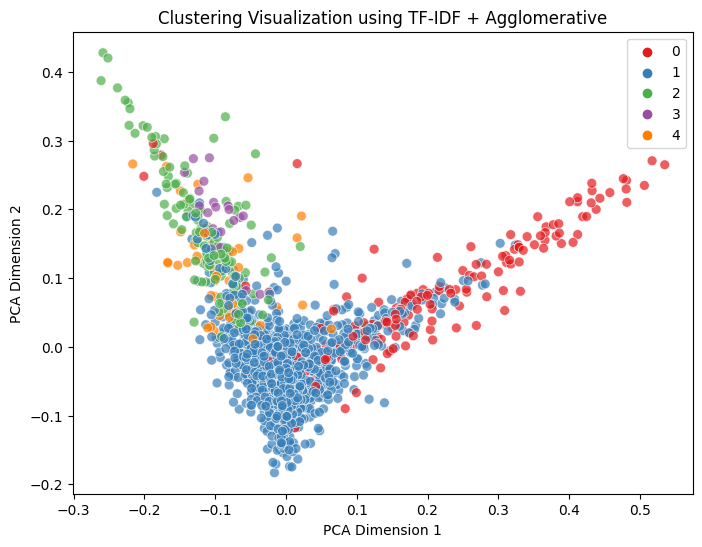

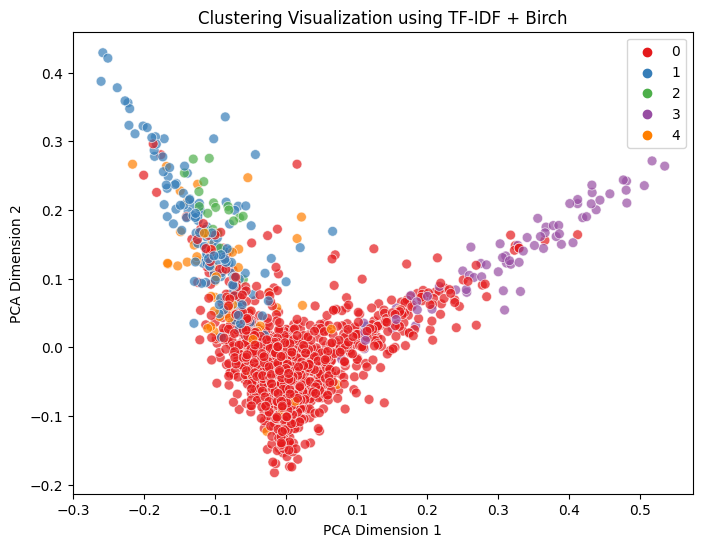

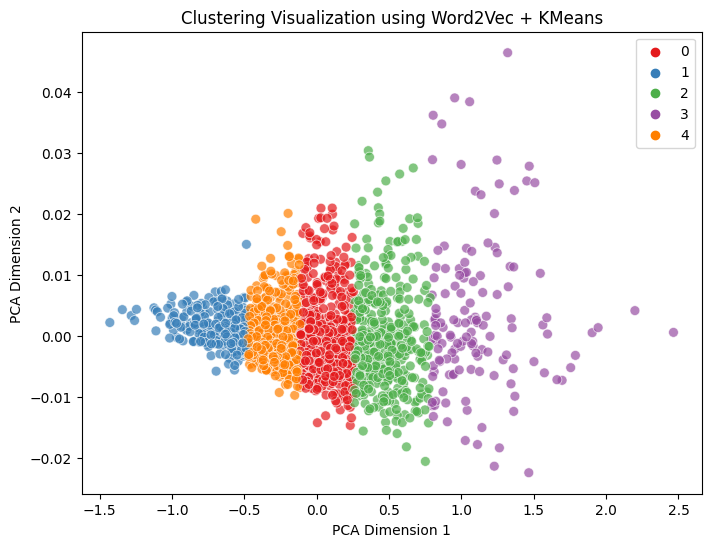

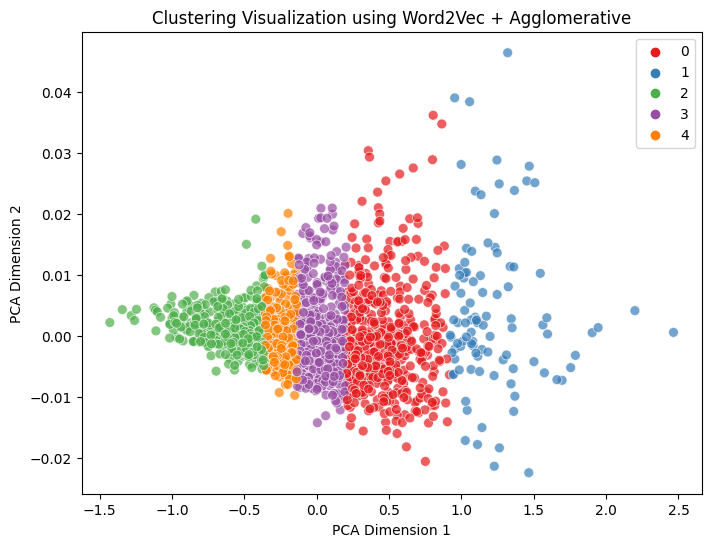

c:\Users\rasikac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(


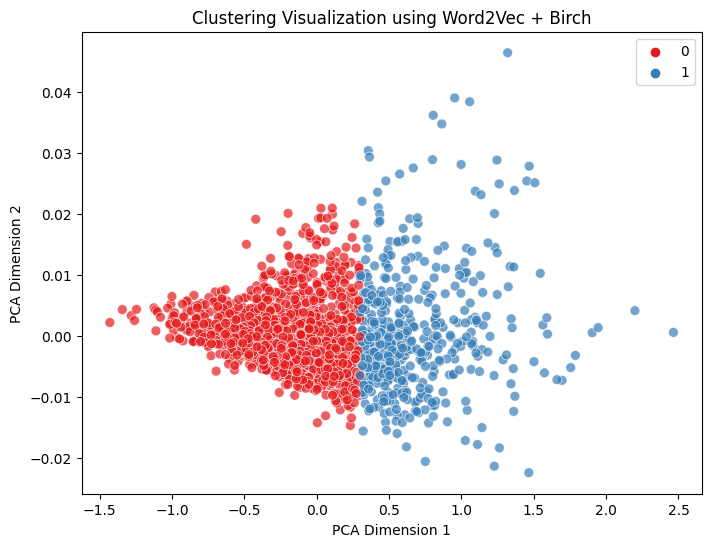

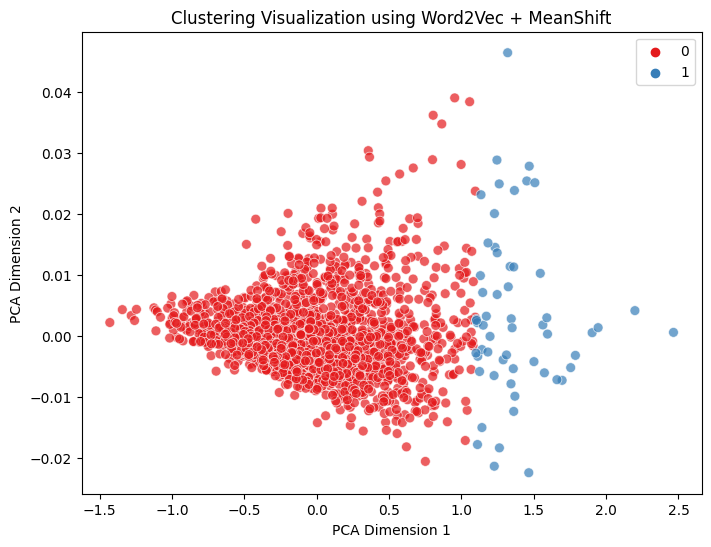

The recommended combination of clustering and vectorization models are:
Vectorization_Method    Word2Vec
Clustering_Method         KMeans
Name: 7, dtype: object


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import warnings

import matplotlib.pyplot as plt  # Importing matplotlib
import seaborn as sns  # Importing seaborn
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=FutureWarning)

output_folder = r'D:\Research\Python\Data\WIP\Clustering'


# Function to load CSV datasets from a folder
def load_csv_datasets(data_folder):
    csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    datasets = []
    for file in csv_files:
        dataset = pd.read_csv(os.path.join(data_folder, file))
        # Drop rows with non-string, null, or numeric values in 'Text_Lemmatized' column
        dataset = dataset.dropna(subset=['Text_Lemmatized'])
        dataset = dataset[dataset['Text_Lemmatized'].apply(lambda x: isinstance(x, str))]
        datasets.append(dataset)
    return datasets

# Function to perform vectorization on textual data using Word2Vec
def vectorize_word2vec(data, word2vec_model):
    document_vectors = np.array([np.mean([word2vec_model.wv[word] for word in word_tokenize(doc) if word in word2vec_model.wv], axis=0) for doc in data])
    return document_vectors

# Function to perform vectorization on textual data using CountVectorizer or TfidfVectorizer
def vectorize_sklearn(data, vectorizer):
    return vectorizer.fit_transform(data).toarray()

# Function to calculate clustering performance measures
def calculate_clustering_performance(X, clusters):
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Number of clusters excluding noise if using DBSCAN
    if n_clusters <= 1:
        return None, None, None
    silhouette = silhouette_score(X, clusters)
    davies_bouldin = davies_bouldin_score(X, clusters)
    calinski_harabasz = calinski_harabasz_score(X, clusters)
    return silhouette, davies_bouldin, calinski_harabasz

def evaluate_combination(silhouette, davies_bouldin, calinski_harabasz):
    # Calculate the overall evaluation score by averaging individual metrics
    overall_score = (silhouette + 1/davies_bouldin + calinski_harabasz) / 3
    return overall_score

def visualize_clusters(X, clusters, method_name):
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Ensure clusters is a 1D array
    clusters = clusters.ravel()

    # 2D scatter plot for visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set1', s=50, alpha=0.7)
    plt.title(f'Clustering Visualization using {method_name}')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.legend()

    # Define the output folder
    output_folder = r'D:\Research\Python\Data\WIP\Clustering'

    # Save the plot to the specified output folder
    output_file = os.path.join(output_folder, f'clustering_visualization_{method_name}.png')
    plt.savefig(output_file)

    plt.show()


def main():
    # Data loading
    data_folder = r'D:\Research\Python\Data\WIP\Spike Data'
    data_frames = load_csv_datasets(data_folder)

    # Vectorization models
    vectorization_methods = [
        ('CountVectorizer', CountVectorizer()),  # Add any desired CountVectorizer parameters
        ('TF-IDF', TfidfVectorizer()),  # Add any desired TfidfVectorizer parameters
        # Word2Vec vectorization (note: word_tokenize is from nltk)
        ('Word2Vec', Word2Vec(sentences=[word_tokenize(doc) for df in data_frames for doc in df['Text_Lemmatized']], vector_size=100, window=5, min_count=1, workers=4))
    ]

    # Clustering techniques
    clustering_methods = [
        ('KMeans', KMeans(n_clusters=5)),  # Replace n_clusters with your desired number of clusters
        ('Agglomerative', AgglomerativeClustering(n_clusters=5)),
        ('DBSCAN', DBSCAN(eps=0.5, min_samples=5)),  # Replace eps and min_samples with appropriate values
        ('Birch', Birch(n_clusters=5)),  # Replace n_clusters with your desired number of clusters
        ('MeanShift', MeanShift()),
        # Add more clustering algorithms if desired
    ]

    # Additional evaluation metrics
    evaluation_metrics = ['Silhouette_Score', 'Davies_Bouldin_Score', 'Calinski_Harabasz_Score']

    # Perform vectorization and clustering, and save results in a list
    clustering_results = []

    for idx, df in enumerate(data_frames):
        X = df['Text_Lemmatized']
        for vec_method_name, vec_method in vectorization_methods:
            if vec_method_name == 'Word2Vec':
                X_vectorized = vectorize_word2vec(X, vec_method)
            else:
                X_vectorized = vectorize_sklearn(X, vec_method)
            for clus_method_name, clus_method in clustering_methods:
                clusters = clus_method.fit_predict(X_vectorized)
                silhouette, davies_bouldin, calinski_harabasz = calculate_clustering_performance(X_vectorized, clusters)
                if silhouette is None or davies_bouldin is None:
                    print(f"Warning: '{vec_method_name}' + '{clus_method_name}' for Dataset_{idx+1} resulted in only one cluster.")
                    continue
                dataset_name = f"Dataset_{idx+1}"
                clustering_results.append((dataset_name, vec_method_name, clus_method_name, silhouette, davies_bouldin, calinski_harabasz))
                
                # Visualize the clusters
                visualize_clusters(X_vectorized, clusters, f'{vec_method_name} + {clus_method_name}')

    # Create a DataFrame from the results and save to CSV
    performance_df = pd.DataFrame(clustering_results, columns=['Dataset_Name', 'Vectorization_Method', 'Clustering_Method'] + evaluation_metrics)

    # Calculate the overall evaluation score for each combination
    performance_df['Overall_Score'] = performance_df.apply(lambda row: evaluate_combination(row['Silhouette_Score'], row['Davies_Bouldin_Score'], row['Calinski_Harabasz_Score']), axis=1)

    output_folder = r'D:\Research\Python\Data\WIP\Clustering'
    output_file = f"{output_folder}\\clustering_performance.csv"

    performance_df.to_csv(output_file, index=False)

    # Get the recommended combination based on the highest overall score
    max_score_idx = performance_df['Overall_Score'].idxmax()
    recommended_combination = performance_df.loc[max_score_idx, ['Vectorization_Method', 'Clustering_Method']]

    print("The recommended combination of clustering and vectorization models are:")
    print(recommended_combination)

if __name__ == "__main__":
    main()
